In [8]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import shap
import seaborn as sns

/opt/anaconda3/envs/mlops/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Top 10 Important Features for Twitter:



,Feature,Coefficient
1,Sentiment_Category_Positive,0.300617
2,Hour,0.060143
0,Sentiment_Category_Neutral,-0.018371
3,Text_Length,0.004012


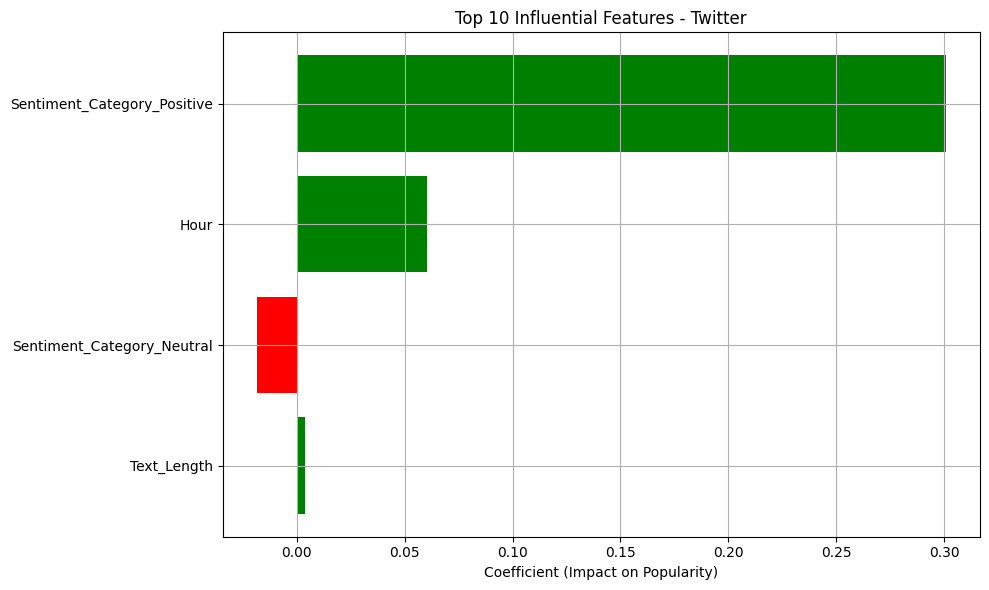


Top 10 Important Features for Instagram:



,Feature,Coefficient
1,Sentiment_Category_Positive,0.300617
2,Hour,0.060143
0,Sentiment_Category_Neutral,-0.018371
3,Text_Length,0.004012


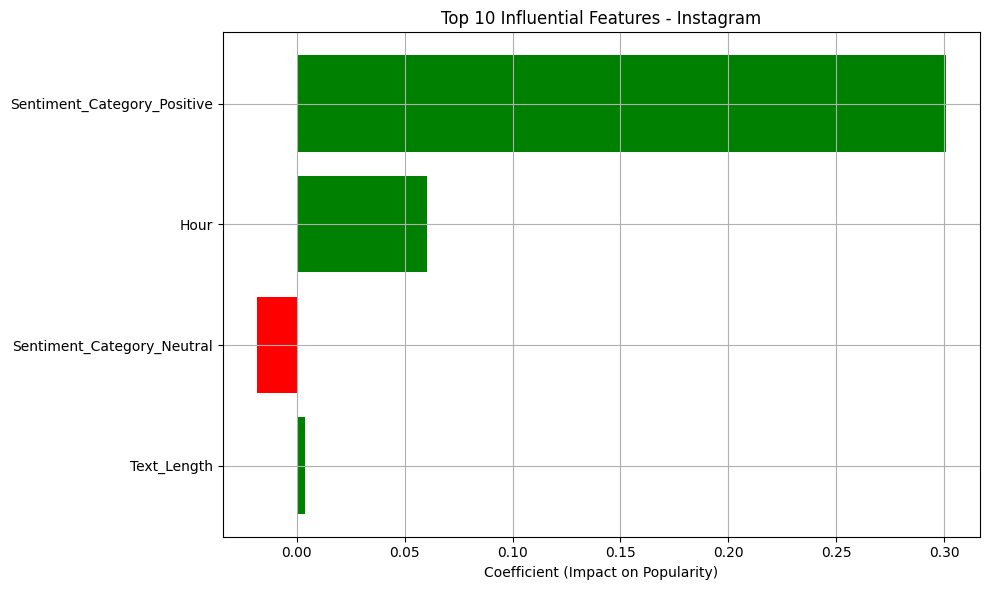


Top 10 Important Features for Facebook:



,Feature,Coefficient
1,Sentiment_Category_Positive,0.300617
2,Hour,0.060143
0,Sentiment_Category_Neutral,-0.018371
3,Text_Length,0.004012


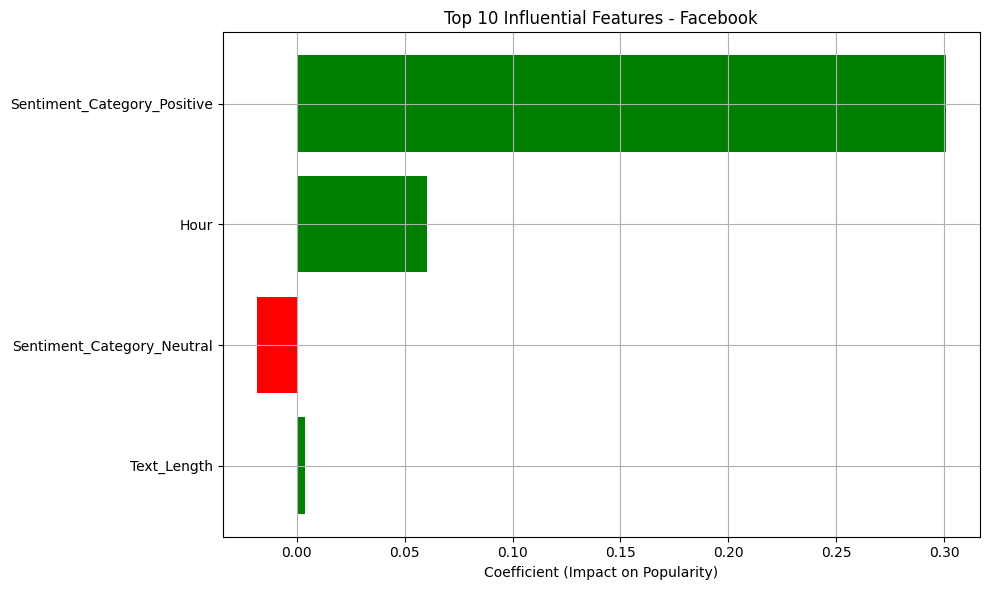

In [7]:
def explain_logistic_model(model, platform_name="Platform"):
    """解释 Logistic 回归模型中每个特征的重要性"""
    clf = model.named_steps['classifier']
    preprocessor = model.named_steps['preprocessor']

    # 提取类别特征名称和编码器
    cat_features = preprocessor.transformers_[0][2]
    encoder = preprocessor.transformers_[0][1]
    cat_feature_names = encoder.get_feature_names_out(cat_features)

    # 数值特征直接 passthrough
    num_features = preprocessor.transformers_[1][2]
    all_feature_names = list(cat_feature_names) + list(num_features)

    # 模型系数
    coef = clf.coef_[0]
    coef_df = pd.DataFrame({
        'Feature': all_feature_names,
        'Coefficient': coef
    }).sort_values(by='Coefficient', key=abs, ascending=False)

    print(f"\nTop 10 Important Features for {platform_name}:\n")
    display(coef_df.head(10))

    # 可视化
    plt.figure(figsize=(10, 6))
    top_features = coef_df.head(10)
    colors = top_features['Coefficient'].apply(lambda x: 'green' if x > 0 else 'red')
    plt.barh(top_features['Feature'][::-1], top_features['Coefficient'][::-1], color=colors[::-1])
    plt.xlabel("Coefficient (Impact on Popularity)")
    plt.title(f"Top 10 Influential Features - {platform_name}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 平台与对应模型路径
platform_models = {
    "Twitter": "model/twitter.pkl",
    "Instagram": "model/Instagram.pkl",
    "Facebook": "model/Facebook.pkl"
}

for platform, model_path in platform_models.items():
    model = joblib.load(model_path)
    explain_logistic_model(model, platform)


In [ ]:
# ==== 加载数据 ====
df = pd.read_csv("df_platform.csv")  # ← 替换为实际数据路径
platform_name = "Instagram"
df_platform = df[df['Platform'] == platform_name].copy()

# ==== 特征选择 ====
features = ['Sentiment_Category', 'Hour', 'Text_Length']
target = 'Popular'
X = df_platform[features]
y_true = df_platform[target]

# ==== 加载模型 ====
model = joblib.load(f"model/Instagram.pkl")

# ==== 生成预测和概率 ====
y_prob = model.predict_proba(X)[:, 1]
y_pred = model.predict(X)

# ==== 添加预测结果列 ====
df_platform['y_true'] = y_true
df_platform['y_pred'] = y_pred
df_platform['y_prob'] = y_prob

# ==== 找出错误预测样本 ====
df_wrong = df_platform[df_platform['y_true'] != df_platform['y_pred']]
print(f"错误样本数量: {len(df_wrong)}")

# ==== 保存错误样本 ====
df_wrong.to_csv(f"errors_{platform_name.lower()}.csv", index=False)
print(f"错误样本已保存为 errors_{platform_name.lower()}.csv")

# ==== 可视化错误样本分布 ====
plt.figure(figsize=(8, 5))
sns.countplot(x='Sentiment_Category', hue='y_true', data=df_wrong)
plt.title(f'错误预测样本的情感类别 - {platform_name}')
plt.xlabel('Sentiment Category')
plt.ylabel('Count')
plt.legend(title='True Label')
plt.tight_layout()
plt.show()

# 也可查看错误样本的时间分布或概率分布
plt.figure(figsize=(8, 5))
sns.histplot(df_wrong['Hour'], bins=24, kde=False)
plt.title(f'错误预测样本的发布时间分布 - {platform_name}')
plt.xlabel('Hour of Day')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'model_instagram.pkl'